In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx

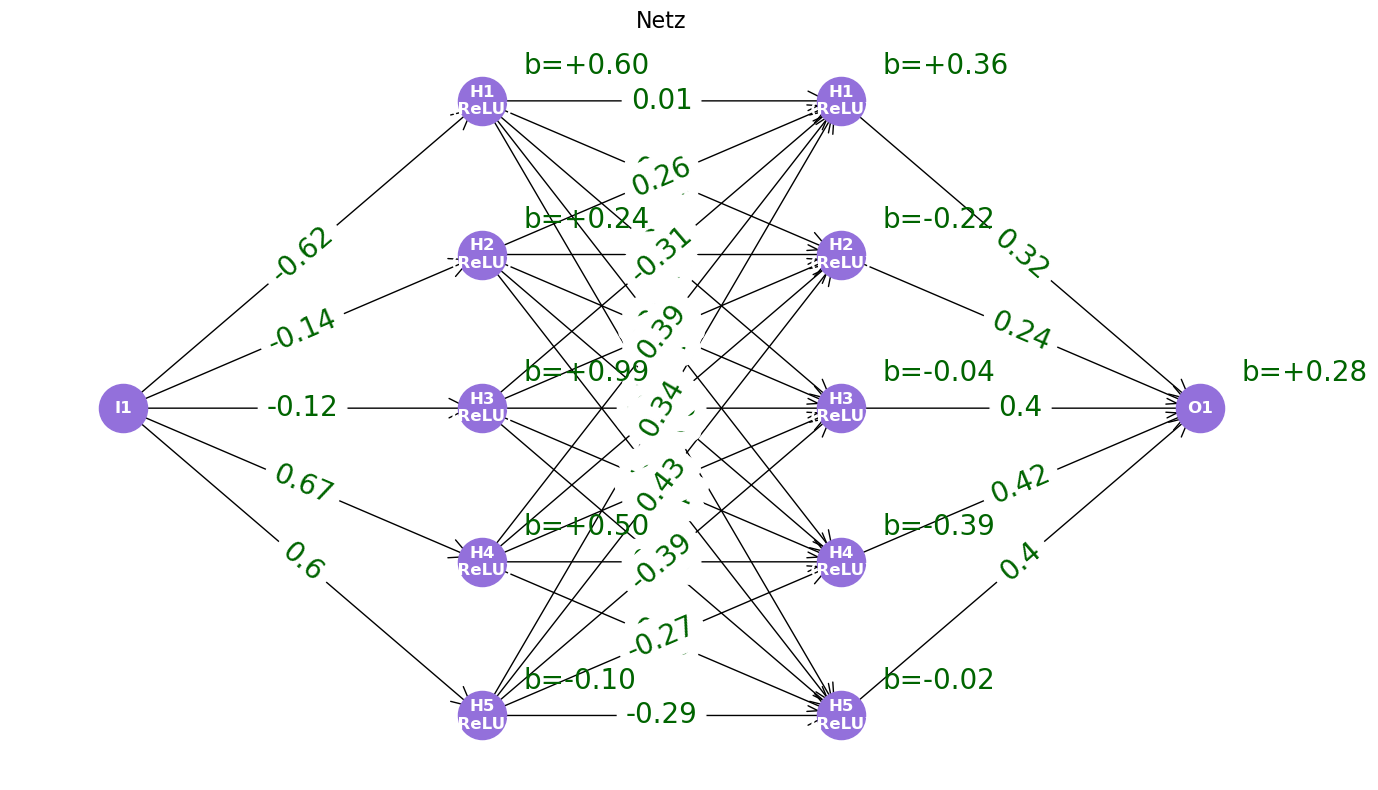

In [22]:
#Klasse des Neuronalen Netzes
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.netz = nn.Sequential(
            nn.Linear(1, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
            #nn.Softmax(dim=0)
        )

    def forward(self, x):
        return self.netz(x)

    def visualize(self, title="Netz", show_edge_labels=True, show_biases=True,
             weight_fmt="{:.2f}", bias_fmt="{:+.2f}"):

        weights = []
        biases = []
        activations = []
        layer_shapes = []

        # Schichten einsammeln (wie bisher)
        for module in self.netz:
            if isinstance(module, nn.Linear):
                w = module.weight.detach().numpy()
                weights.append(w)
                biases.append(module.bias.detach().numpy())   # <— Bias speicherst du bereits
                layer_shapes.append((w.shape[1], w.shape[0]))
            elif isinstance(module, (nn.ReLU, nn.Tanh, nn.Sigmoid, nn.Softmax)):
                activations.append(module.__class__.__name__)

        # Layer-Beschreibung
        layers = [{"name": "Input", "size": layer_shapes[0][0]}]
        for i, (_, out_dim) in enumerate(layer_shapes):
            lname = "Output" if i == len(layer_shapes) - 1 else f"Hidden{i+1}"
            layers.append({"name": lname, "size": out_dim})

        # Graph vorbereiten
        G = nx.DiGraph()
        pos = {}
        layer_x_spacing = 3
        neuron_y_spacing = 2
        node_labels = {}
        layer_positions = []

        # Knoten platzieren & labeln
        for l, layer in enumerate(layers):
            ids = []
            size = layer["size"]
            y_offset = (size - 1) * neuron_y_spacing / 2
            for n in range(size):
                node = f"L{l}_N{n}"
                G.add_node(node)
                pos[node] = (l * layer_x_spacing, -(n * neuron_y_spacing - y_offset))
                ids.append(node)

                label = f"{layer['name'][0]}{n+1}"
                if 0 < l < len(layers) - 1:  # Hidden-Layer: Aktivierung anzeigen
                    act_fn = activations[l - 1] if l - 1 < len(activations) else "None"
                    label += f"\n({act_fn})"
                node_labels[node] = label

            layer_positions.append(ids)

        # Kanten + Weights
        for l in range(len(weights)):
            w = weights[l]  # shape: (out_dim, in_dim)
            for i, src in enumerate(layer_positions[l]):
                for j, tgt in enumerate(layer_positions[l + 1]):
                    weight_val = w[j, i]
                    G.add_edge(src, tgt, weight=round(float(weight_val), 2))

        # Zeichnen
        plt.figure(figsize=(14, 8))
        nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="mediumpurple")
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_color="white", font_weight="bold")
        nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=35)

        if show_edge_labels:
            edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                     font_color="darkgreen", font_size=20)

        # >>> Bias-Annotationen (NEU) <<<
        # biases[l] gehört zur Zielschicht (layer_positions[l+1])
        if show_biases:
            for l in range(len(biases)):
                b_vec = biases[l]
                tgt_nodes = layer_positions[l + 1]  # Ziel-Layer-Knoten
                for j, node in enumerate(tgt_nodes):
                    bx, by = pos[node]
                    bval = float(b_vec[j])
                    # Text leicht rechts/oben vom Knoten platzieren
                    plt.text(bx + 0.35, by + 0.35, f"b={bias_fmt.format(bval)}",
                         fontsize=20, color="darkgreen")

        plt.axis("off")
        plt.title(title, fontsize=16)
        plt.tight_layout()
        plt.show()

        
    def get_θ(self):
        θ = []
        for module in self.netz:
            if isinstance(module, nn.Linear):
                θ.append(module.weight.detach().clone().requires_grad_(True))
                θ.append(module.bias.detach().clone().requires_grad_(True))
        return θ

    def replace_θ(self, θ_new):
        LAYER_INDEX = 0
        for module in self.netz:
            if isinstance(module, nn.Linear):
                module.weight.data.copy_(θ_new[LAYER_INDEX])
                LAYER_INDEX += 1

        
model = NN()

#model.get_θ()
#model.replace_θ(θ_new)
#model.get_θ()
model.visualize()

In [ ]:
#Benutzen des Modells
x = torch.tensor([1.0])
y = model(x)

print(y)

print(model.get_θ())